In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [6]:
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [7]:
# import keras_unet
from keras.optimizers import Adam, SGD
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance

from keras.models import load_model

In [8]:
MODEL_PATH = '../../models'
DATA_PATH = '../../data/processed'

In [9]:
def load_data(year, img_h=1400, img_w=1400):

    X = []
    y = []

    data_dir = os.path.join(DATA_PATH, str(year))
    frames_dir = os.path.join(data_dir, 'frames')
    masks_dir = os.path.join(data_dir, 'masks')

    for file in sorted(os.listdir(frames_dir)):
        if file.startswith('R'):
            filename = file.split('.')[0]

            frame = np.load(os.path.join(frames_dir, filename + '.npy'))
            mask = np.load(os.path.join(masks_dir, filename + '_labels.npy'))
            X.append(frame[:img_h, :img_w, :])
            y.append(mask[:img_h, :img_w])

    X = np.array(X)
    y = np.array(y)

    return X, y

In [10]:
def standardize(X):
    
    # flatten X to 2D array
    X_reshaped = X.reshape(-1, X.shape[-1])
    
    # standardize on columns
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_reshaped)
    
    # reshape X to original shape
    X_final = X_scaled.reshape(X.shape)
    
    return X_final

## Loading trained U-Net weights

In [ ]:
dependencies = { 'iou': iou }
model = load_model(os.path.join(MODEL_PATH, 'segm_model_v3.h5'), custom_objects=dependencies)

## Loading, shaping and standardizing 2018 data

In [12]:
X, y = load_data(year=2018)

X_scaled = standardize(X)
y = y.reshape(y.shape[0], y.shape[1], y.shape[2], 1)

## Get smaller patches/crops from bigger image

In [13]:
from keras_unet.utils import get_patches

X_crops = []
y_crops = []

patch_size = 512
stride_size = 512

for i, x in enumerate(X_scaled):

    x_ = get_patches(
        img_arr=x,
        size=patch_size,
        stride=stride_size)

    y_ = get_patches(
        img_arr=y[i], 
        size=patch_size, 
        stride=stride_size)

    X_crops.append(x_)
    y_crops.append(y_)
    
X_crops = np.array(X_crops)
y_crops = np.array(y_crops)

In [16]:
X_crops = X_crops.reshape(X_crops.shape[0] * X_crops.shape[1],
                          X_crops.shape[2],
                          X_crops.shape[3],
                          X_crops.shape[4])

y_crops = y_crops.reshape(y_crops.shape[0] * y_crops.shape[1],
                          y_crops.shape[2],
                          y_crops.shape[3],
                          y_crops.shape[4])

## Predicting on image patches using U-Net model

In [18]:
y_pred = model.predict(X_crops)

In [19]:
# Rounding probabilities to 0/1
y_pred_binary = np.round_(y_pred, 0)

## Results

In [51]:
def intersection_over_union(confusion_matrix):
    """ Intersection-over-union metric for image segmentation """
  
    tn, fp, fn, tp = confusion_matrix.ravel()
    iou = tp / (tp + fn + fp)
    return iou

def print_metrics(y_true, y_pred):
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    cm = confusion_matrix(y_true_flat, y_pred_flat)

    print('Accuracy: %.2f' % accuracy_score(y_true_flat, y_pred_flat))
    print('Intersection-over-Union: %.2f' % intersection_over_union(cm))
    print('Confusion Matrix: \n', cm)
    print('Classification report:\n', classification_report(y_true_flat, y_pred_flat))

In [52]:
print_metrics(y_crops, y_pred_binary)

Accuracy: 0.94
Intersection-over-Union: 0.82
Confusion Matrix: 
 [[15977286   888105]
 [  617636  6634221]]
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.95  16865391
           1       0.88      0.91      0.90   7251857

    accuracy                           0.94  24117248
   macro avg       0.92      0.93      0.93  24117248
weighted avg       0.94      0.94      0.94  24117248



## Visualizing predictions

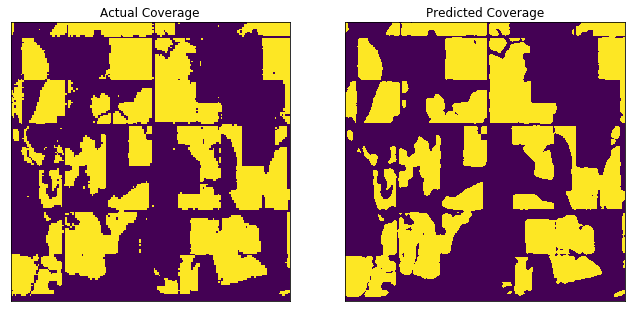

In [45]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(11,6))

plt.subplot(121)
plt.title('Actual Coverage')
plt.xticks([])
plt.yticks([])
plt.imshow(y_crops[0].reshape(512, 512))

plt.subplot(122)
plt.title('Predicted Coverage')
plt.xticks([])
plt.yticks([])
plt.imshow(y_pred_binary[0].reshape(512, 512))

In [53]:
print_metrics(y_crops[0], y_pred_binary[0])

Accuracy: 0.94
Intersection-over-Union: 0.87
Confusion Matrix: 
 [[148331   4609]
 [  9862  99342]]
Classification report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95    152940
           1       0.96      0.91      0.93    109204

    accuracy                           0.94    262144
   macro avg       0.95      0.94      0.94    262144
weighted avg       0.95      0.94      0.94    262144

